# Image Classification Using HOG+SVM 

In this we will use GTI vehicle image database available here: http://www.gti.ssr.upm.es/data/Vehicle_database.html.
This dataset has cars and non-cars images ~8k. Images are of 64*64 in resolution. The goal is to train HOG created features with Support Vector Machines(SVC). The process is follows:
*  Make Dataset.
*  Show some samples.
*  Show HOG features sample.
*  Make HOG features vectors.
*  Make Preprocessed image + HOG features vectors.
*  Train 2 SVMs based on 2 different data vectors created.
*  Predict with SVMs.
*  Show some results.



In [ ]:
from PIL import Image
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage import feature, exposure
import imutils
from sklearn.svm import LinearSVC

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/My Drive/train_datasets/cars-noncars.rar", 
                         outdir="/content/")

     |████████████████████████████████| 81kB 2.3MB/s 
patool: Extracting /content/drive/My Drive/train_datasets/cars-noncars.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/train_datasets/cars-noncars.rar"
patool:     with cwd='/content/'
patool: ... /content/drive/My Drive/train_datasets/cars-noncars.rar extracted to `/content/'.


'/content/'

1. Make Dataset

In [ ]:
DATA_DIR = '/content/OwnCollection/'
DATA = []
Y = []


def make_dataset(data_dir):

  vehicles_path = os.path.join(data_dir, 'vehicles')
  non_vehicles_path = os.path.join(data_dir, 'non-vehicles')

  for fld in os.listdir(vehicles_path):
    cur_dir = os.path.join(vehicles_path, fld)

    for img in os.listdir(cur_dir):
      if img.endswith(".png"):
        img = np.asarray(Image.open(os.path.join(cur_dir, img)))
        DATA.append(img)
        Y.append(1)

  for fld in os.listdir(non_vehicles_path):
    cur_dir = os.path.join(non_vehicles_path, fld)

    for img in os.listdir(cur_dir):
      if img.endswith(".png"):
        img = np.asarray(Image.open(os.path.join(cur_dir, img)))
        DATA.append(img)
        Y.append(0)

make_dataset(DATA_DIR)

X_train, X_test, Y_train, Y_test = train_test_split(DATA, Y, test_size= 0.3)

print('Total DATA samples:', len(Y))
print('Total Train samples:', len(Y_train))
print('Total Test samples:', len(Y_test))

Total DATA samples: 7325
Total Train samples: 5127
Total Test samples: 2198


2. Show some samples

Cars:1, Non-cars:0


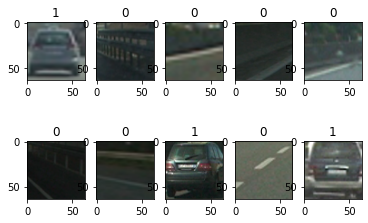

In [ ]:
#show some sample data

r = 2
c = 5
f, axs = plt.subplots(r,c)

a= 0

for i in range(r):
  for j in range(c):
    axs[i,j].imshow(X_train[a])
    axs[i,j].set_title(Y_train[a])
    a+=1
print('Cars:1, Non-cars:0')

As our data is already pre-processed i.e image is 64*64 by defualt, we don't need to do much but for other dataset make sure to preprocess the image to same sie(also not losing the image details).

In [ ]:
X_train[0].shape

(64, 64, 3)

3. Show HOG features sample 

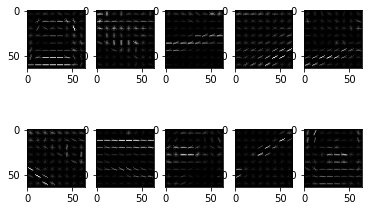

In [ ]:
# sample hog features plot

a = 0
f, axs = plt.subplots(2, 5)
for i in range(r):
  for j in range(c):
    (HOG_features, Hog_image) = feature.hog(X_train[a], 9, visualize=True, 
                                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                          feature_vector=True)
    img = exposure.rescale_intensity(Hog_image, out_range=(0, 255))
    img = img.astype('int').reshape(64, 64)
    axs[i,j].imshow(img, cmap='gray')
    a+=1


4. Prepare both datasets (Pre-processed / not processsed)

In [ ]:
def make_hog_feaures(image):
  # image values is already normalized under hog function
  Hog_features = feature.hog(image, orientations=9, 
                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                            feature_vector=True)
  return Hog_features

In [ ]:
# preprocessing such as finding edges and taking largest egde and make edge map out of it

not_processed = 0

def preprocess_image(image):
  global not_processed
  edges = cv2.Canny(image, 20, 50)
  cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  if cnts:
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
    img = image[y:y + h, x:x + w]
    img = cv2.resize(img, (64, 64))
    return img
  else:
    not_processed+=1
    return image  

In [ ]:
train_features = []
prec_train_features = []


for image in X_train:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # image = preprocess_image(image)
  hog_features = make_hog_feaures(image)
  train_features.append(hog_features)  

for image in X_train:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = preprocess_image(image)
  hog_features = make_hog_feaures(image)
  prec_train_features.append(hog_features)


In [ ]:
print('Number of not processsed in SVC2:', not_processed)

Number of not processsed in SVC2: 133


5. Train SVMs on HOG features

In [ ]:
# train a svm1 (non processed only hog features)

svc1 = LinearSVC(tol=0.0001, random_state=42)
svc1.fit(train_features, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [ ]:
# train svm2 (processed + hog)

svc2 = LinearSVC(tol=0.0001, random_state=42)
svc2.fit(prec_train_features, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

6. Predict with them

In [ ]:
# predict with SVC1

correct = 0

for image,label in zip(X_test, Y_test):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  features = make_hog_feaures(image)
  yhat = svc1.predict((features).reshape(1, features.shape[0]))
  if yhat[0] == label:
    correct+=1

print('{0} Correct out of {1}'.format(correct, len(Y_test)))   
print("Accuracy:", correct/len(Y_test)*100)

2098 Correct out of 2198
Accuracy: 95.4504094631483


In [ ]:
# predict with SVC2

correct = 0

for image,label in zip(X_test, Y_test):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = preprocess_image(image)
  features = make_hog_feaures(image)
  yhat = svc2.predict((features).reshape(1, features.shape[0]))
  if yhat[0] == label:
    correct+=1

print('{0} Correct out of {1}'.format(correct, len(Y_test)))   
print("Accuracy:", correct/len(Y_test)*100)

1771 Correct out of 2198
Accuracy: 80.57324840764332


The reason might be becuase the image size was very small, becuase of which Canny could not find good edges.

7. Show final results with images

Cars:1, Non-cars:0


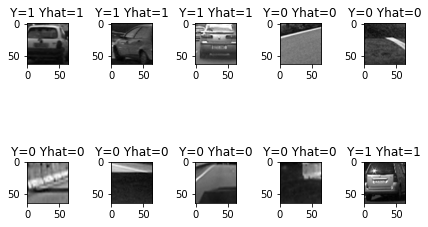

In [ ]:
# SVC results

a = 0
f, axs = plt.subplots(2, 5)
f.tight_layout()
for i in range(r):
  for j in range(c):

    image = cv2.cvtColor(X_test[a], cv2.COLOR_BGR2GRAY)
    features = make_hog_feaures(image)
    yhat = svc1.predict((features).reshape(1, features.shape[0]))
    axs[i,j].imshow(image, cmap='gray')
    axs[i,j].set_title("Y={0} Yhat={1}".format(Y_test[a], yhat[0]))
    a+=1
print('Cars:1, Non-cars:0')

**Summary**: Even though the not pre-processed dataset did well wit this example does not means this is always going to be the case. Few things to learn here:
* This is method proves to be benificial when processing requirements are low(pi divces)
* Preprocess(finding edges) don't do well in smaller size images.
* As always many things depend on input dataset quality.
* This method can be used to recognize faces also, but fairly amount of images per face is a good requirement. 
